In [5]:
import numpy as np
import matplotlib.pyplot as plt
import rebound
import reboundx
import pandas as pd
%matplotlib inline
import scipy.integrate as integrate

In [6]:
from celmech.disturbing_function import laplace_b as b
def ConstructMatrix(mu1, mu3, P1, P2, P3):
    n1 = 2*np.pi/P1
    n2 = 2*np.pi/P2
    n3 = 2*np.pi/P3
    alpha12 = (n1/n2)**(-2/3)
    alpha13 = (n1/n3)**(-2/3)
    alpha23 = (n2/n3)**(-2/3)
    A11 = n1*mu3*alpha13**2*b(1.5, 1, 0, alpha13)/(4*(1+mu1))
    A13 = -n1*mu3*alpha13**2*b(1.5, 2, 0, alpha13)/(4*(1+mu1))
    A21 = -n2*mu1*alpha12*b(1.5, 2, 0, alpha12)/4
    A22 = n2*(mu1*alpha12*b(1.5, 1, 0, alpha12)+mu3*alpha23**2*b(1.5, 1, 0, alpha23))/4
    A23 = -n2*mu3*alpha23**2*b(1.5, 2, 0, alpha23)/4
    A31 = -n3*mu1*alpha13*b(1.5, 2, 0, alpha13)/(4*(1+mu3))
    A33 = n3*mu1*alpha13*b(1.5, 1, 0, alpha13)/(4*(1+mu3))
    return np.array([[A11,0,A13],[A21,A22,A23],[A31,0,A33]])

In [7]:
def LaplaceLagrangeValue(P1, P2, P3, mu1, mu3, ecc, pom):
    ecc1, ecc2, ecc3 = ecc
    pom1, pom2, pom3 = pom
    h1 = ecc1*np.sin(pom1)
    h2 = ecc2*np.sin(pom2)
    h3 = ecc3*np.sin(pom3)
    k1 = ecc1*np.cos(pom1)
    k2 = ecc2*np.cos(pom2)
    k3 = ecc3*np.cos(pom3)
    H = np.array([h1,h2,h3])
    K = np.array([k1,k2,k3])
    E = np.linalg.eig(ConstructMatrix(mu1, mu3, P1, P2, P3))[1]
    Sy = np.matmul(np.linalg.inv(E),H)
    Sx = np.matmul(np.linalg.inv(E),K)
    beta1 = np.arctan2(Sy[0],Sx[0])
    beta2 = np.arctan2(Sy[1],Sx[1])
    beta3 = np.arctan2(Sy[2],Sx[2])
    S1 = np.sqrt(Sy[0]**2+Sx[0]**2)
    S2 = np.sqrt(Sy[1]**2+Sx[1]**2)
    S3 = np.sqrt(Sy[2]**2+Sx[2]**2)
    e11 = E[0][0]*S1
    e21 = E[1][0]*S1
    e31 = E[2][0]*S1
    e12 = E[0][1]*S2
    e22 = E[1][1]*S2
    e32 = E[2][1]*S2
    e13 = E[0][2]*S3
    e23 = E[1][2]*S3
    e33 = E[2][2]*S3
    g1 = np.linalg.eig(ConstructMatrix(mu1, mu3, P1, P2, P3))[0][0]
    g2 = np.linalg.eig(ConstructMatrix(mu1, mu3, P1, P2, P3))[0][1]
    g3 = np.linalg.eig(ConstructMatrix(mu1, mu3, P1, P2, P3))[0][2]
    return np.array([g1, g2, g3]), np.array([beta1, beta2, beta3]), np.array([[e11, e12, e13], [e21, e22, e23], [e31, e32, e33]])

In [1]:
def simulate (P1, P2, P3, mu1, mu3, ecc, pom, timescale):
    ecc1, ecc2, ecc3 = ecc
    pomega1, pomega2, pomega3 = pom
    
    # start simulation
    sim = rebound.Simulation()
    sim.units = ('yr', 'AU', 'Msun')

    # add star, planet 1
    sim.add(m=1.)
    sim.add(m=mu1, P=P1, e=ecc1, pomega=pomega1)
    sim.add(m=mu3, P=P3, e=ecc3, pomega=pomega3)
    ps = sim.particles
    ps[1].r = ps[1].a*(ps[1].m/3/ps[0].m)**(1/3)
    ps[2].r = ps[2].a*(ps[2].m/3/ps[0].m)**(1/3)

    # add test particle
    sim.add(P=P2, e=ecc2, pomega=pomega2)
    sim.move_to_com()
    sim.integrator = "whfast"
    sim.dt = sim.particles[1].P/20
    sim.collision = "direct"
    
    Nout=400
    ecc1, ecc2, ecc3, ecc21, ecc32, ecc31,ecm = np.zeros(Nout),np.zeros(Nout),np.zeros(Nout),np.zeros(Nout),np.zeros(Nout),np.zeros(Nout),np.zeros(Nout)
    times = np.linspace(0,timescale,Nout)
    
    for i, time in enumerate(times):
        try:
            sim.integrate(time)
            info_1 = sim.particles[1].calculate_orbit(primary=sim.particles[0])
            info_2 = sim.particles[3].calculate_orbit(primary=sim.particles[0])
            info_3 = sim.particles[2].calculate_orbit(primary=sim.particles[0])
            p1, p2, p3, e1, e2, e3 = info_1.pomega, info_2.pomega, info_3.pomega, info_1.e, info_2.e, info_3.e
            e1vec = np.array([e1*np.cos(p1),e1*np.sin(p1)])
            e2vec = np.array([e2*np.cos(p2),e2*np.sin(p2)])
            e3vec = np.array([e3*np.cos(p3),e3*np.sin(p3)])
            e21vec = e2vec - e1vec
            e32vec = e3vec - e2vec
            e31vec = e3vec - e1vec
            e21_y = e21vec[1]
            e21_x = e21vec[0]
            e32_y = e32vec[1]
            e32_x = e32vec[0]
            e31_y = e31vec[1]
            e31_x = e32vec[0]
            ecc1[i] = e1
            ecc2[i] = e2
            ecc3[i] = e3
            ecc21[i] = np.linalg.norm(e21vec)
            ecc32[i] = np.linalg.norm(e32vec)
            ecc31[i] = np.linalg.norm(e31vec)
            ecm[i] = np.linalg.norm(mu1*e1vec+mu3*e3vec)/(mu1+mu3)
        except rebound.Collision:
            break
    
    return times, ecc1, ecc2, ecc3, ecc21, ecc32, ecc31, ecm

In [2]:
def LaplaceLagrange(P1, P2, P3, mu1, mu3, ecc, pom, timescale):
    g, beta, E = LaplaceLagrangeValue(P1, P2, P3, mu1, mu3, ecc, pom)
    g1, g2 , g3 = g
    beta1, beta2,beta3 = beta
    e1j, e2j, e3j = E
    e11, e12, e13 = e1j
    e21, e22, e23 = e2j
    e31, e32, e33 = e3j
    Nout=400
    ecc1, ecc2, ecc3, ecc21, ecc32, ecc31,ecm = np.zeros(Nout),np.zeros(Nout),np.zeros(Nout),np.zeros(Nout),np.zeros(Nout),np.zeros(Nout),np.zeros(Nout)
    times = np.linspace(0,timescale,Nout)
    for i, time in enumerate(times):
        e1y = e11*np.sin(g1*time+beta1) + e12*np.sin(g2*time+beta2) + e13*np.sin(g3*time+beta3)
        e1x = e11*np.cos(g1*time+beta1) + e12*np.cos(g2*time+beta2) + e13*np.cos(g3*time+beta3)
        e2y = e21*np.sin(g1*time+beta1) + e22*np.sin(g2*time+beta2) + e23*np.sin(g3*time+beta3)
        e2x = e21*np.cos(g1*time+beta1) + e22*np.cos(g2*time+beta2) + e23*np.cos(g3*time+beta3)
        e3y = e31*np.sin(g1*time+beta1) + e32*np.sin(g2*time+beta2) + e33*np.sin(g3*time+beta3)
        e3x = e31*np.cos(g1*time+beta1) + e32*np.cos(g2*time+beta2) + e33*np.cos(g3*time+beta3)
        e1vec = np.array([e1x,e1y])
        e2vec = np.array([e2x,e2y])
        e3vec = np.array([e3x,e3y])
        e21vec = e2vec - e1vec
        e32vec = e3vec - e2vec
        e31vec = e3vec - e1vec
        ecc21[i] = np.linalg.norm(e21vec)
        ecc32[i] = np.linalg.norm(e32vec)
        ecc31[i] = np.linalg.norm(e31vec)
        ecc1[i] = np.linalg.norm(e1vec)
        ecc2[i] = np.linalg.norm(e2vec)
        ecc3[i] = np.linalg.norm(e3vec)
        ecm[i] = np.linalg.norm(mu1*e1vec+mu3*e3vec)/(mu1+mu3)
    return times, ecc1, ecc2, ecc3, ecc21, ecc32, ecc31, ecm

In [40]:
def compare(P1, P2, P3, mu1, mu3, ecc, pom, timescale):
    fig, axarr = plt.subplots(nrows=7, figsize=(12,18))
    times, ecc1, ecc2, ecc3, ecc21, ecc32, ecc31, ecm = simulate (P1, P2, P3, mu1, mu3, ecc, pom, timescale)
    times_L, ecc1_L, ecc2_L, ecc3_L, ecc21_L, ecc32_L, ecc31_L, ecm_L = LaplaceLagrange(P1, P2, P3, mu1, mu3, ecc, pom, timescale)
    
    axarr[0].plot(times, ecc21, 'k.')
    axarr[0].plot(times_L, ecc21_L, 'b.')
    axarr[0].set_ylabel('ecc21')
    
    axarr[1].plot(times, ecc32, 'k.')
    axarr[1].plot(times_L, ecc32_L, 'b.')
    axarr[1].set_ylabel('ecc32')
    
    axarr[2].plot(times, ecc31, 'k.')
    axarr[2].plot(times_L, ecc31_L, 'b.')
    axarr[2].set_ylabel('ecc31')
    
    axarr[3].plot(times, ecc1, 'k.')
    axarr[3].plot(times_L, ecc1_L, 'b.')
    axarr[3].set_ylabel('ecc1')
    
    axarr[4].plot(times, ecc2, 'k.')  
    axarr[4].plot(times_L, ecc2_L, 'b.')
    axarr[4].set_ylabel('ecc2')
    
    axarr[5].plot(times, ecc3, 'k.')  
    axarr[5].plot(times_L, ecc3_L, 'b.')
    axarr[5].set_ylabel('ecc3')
    
    axarr[6].plot(times, ecm, 'k.')
    axarr[6].plot(times_L, ecm_L, 'b.')
    axarr[6].set_ylabel('ecm')
    axarr[6].set_xlabel('time (yr)')

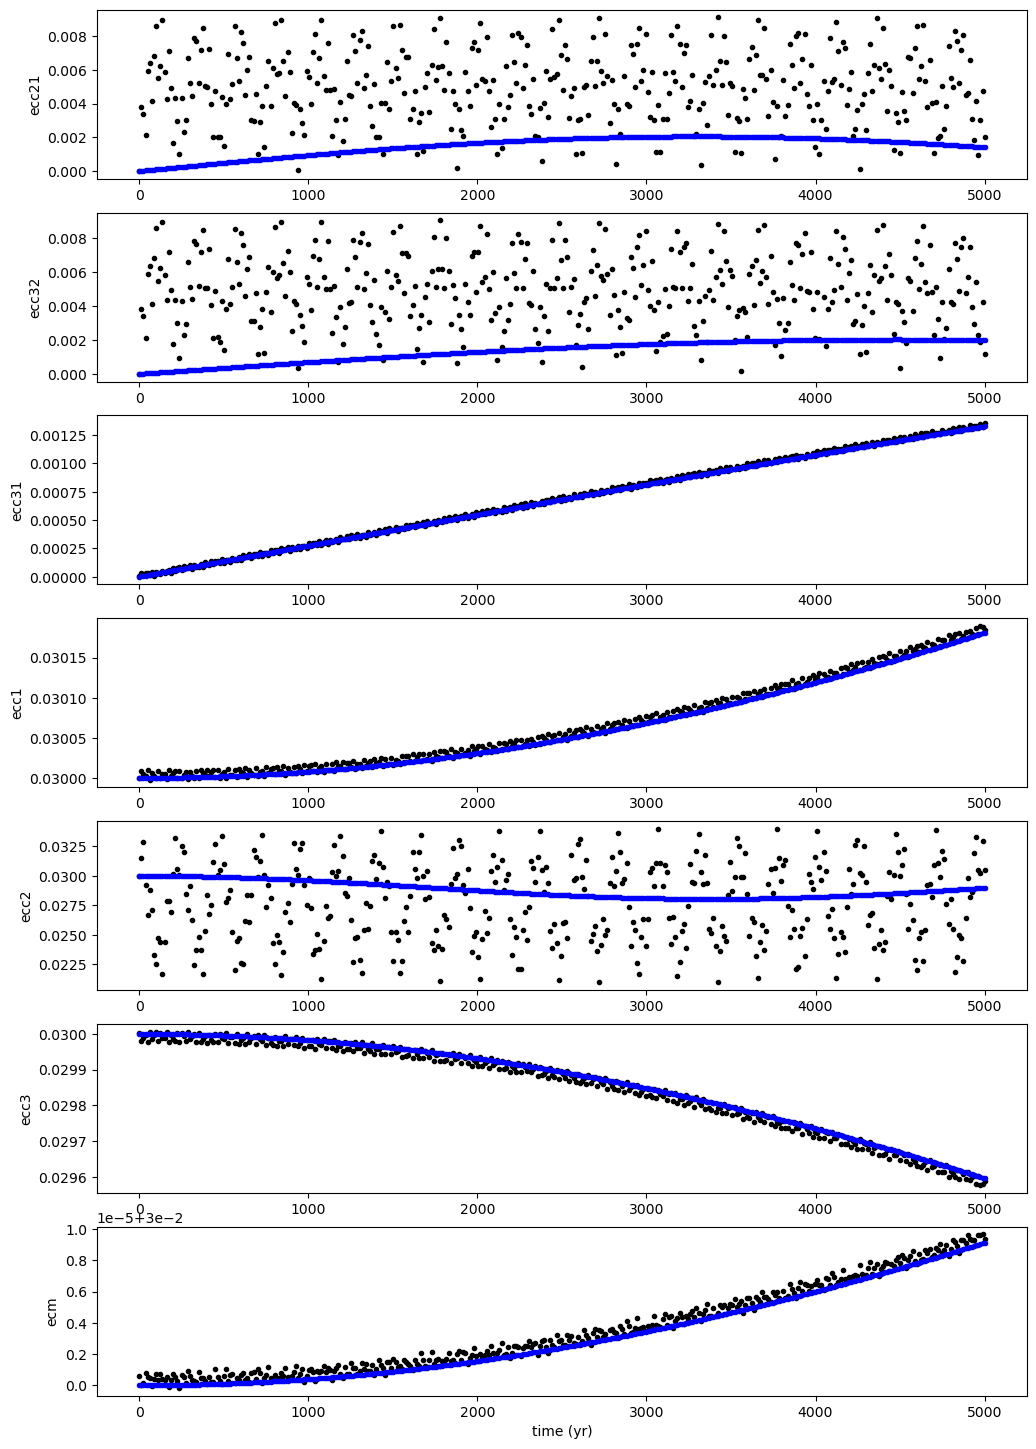

In [52]:
compare(0.05*5/6, 0.05*1, 0.05*1.209, 5e-7, 2e-7, (0.03,0.03,0.03), (0,0,0), 0.05*1e5)

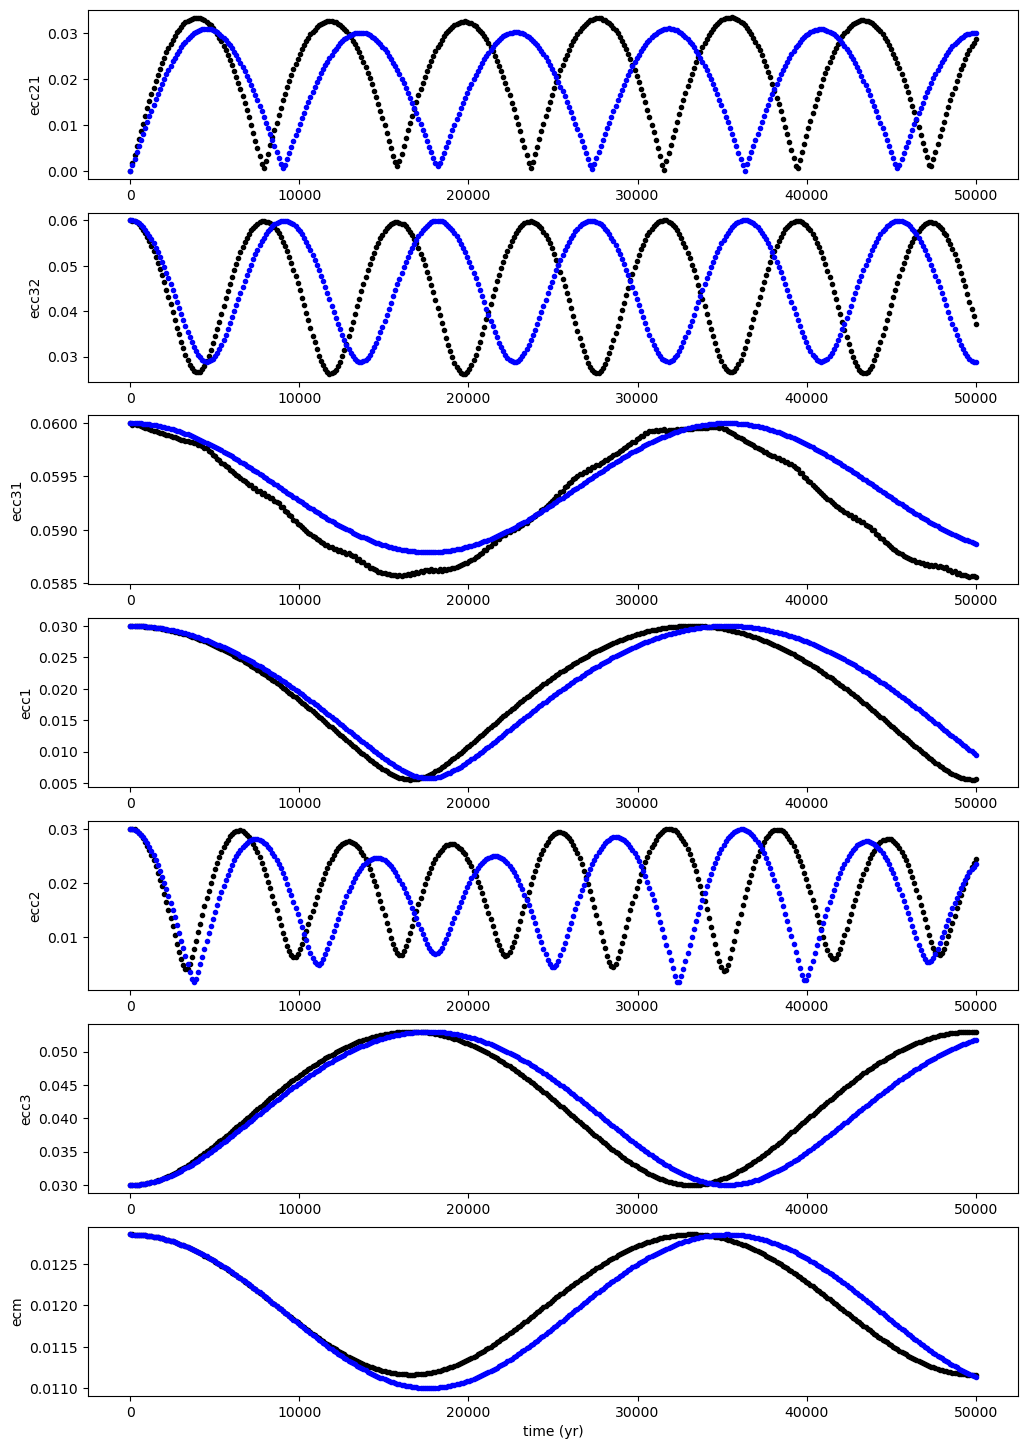

In [46]:
compare(0.05*0.827, 0.05*1, 0.05*1.209, 5e-7, 2e-7, (0.03,0.03,0.03), (0,0,np.pi), 0.05*1e6)

In [23]:
LaplaceLagrangeValue(0.05*0.65, 0.05*1, 0.05*1.55, 0.2e-5, 1e-5, (0.04,0.04,0.04), (0,0.2,0.4))

(array([2.36497870e-03, 5.57274515e-04, 3.99750887e-05]),
 array([-0.35495881, -0.70557267,  0.36156737]),
 array([[ 0.        ,  0.01615579,  0.02961645],
        [ 0.00660155,  0.00239651,  0.03334425],
        [ 0.        , -0.00175484,  0.0408174 ]]))